In [6]:
import sys
sys.path.insert(0, '../src/')

import pickle
import warnings
warnings.filterwarnings('ignore')
import time


import numpy as np
from matplotlib import pyplot as plt
import scipy.sparse as sp
from sklearn.metrics import roc_auc_score, average_precision_score


#from netgan.netgan import *
#from netgan import utils

from net.utils import *
from net import utils_netgan as utils
import net.net as net

In [7]:
def grid_train(Model, train_graph, val_ones, val_zeros, Hs, EOs, 
               test_every=50, max_steps=2000):
    """Trains models with specified bottlenecks until specified edge overlaps are achieved and returns their
       graph statistics.
    
    Parameters
    ----------
    Model: net.Net class
               The model class used for training.
    train_graph: sparse matrix
               The train graph.
    val_ones: array
               Validation edges in train graph.
    val_zeros: array
               Validation non-edges in train graph.               
    Hs: list
               Bottlenecks, for which the model is trained.
    EOs: list
               Edge overlaps, for which the model is trained.
    test_every: integer
               Controls how often the edge overlap for stopping is tested during training.
    max_steps: integer
               Maximum number of training steps allowed to achieve the next edge overlap, starting from the
               model that achieves previous edge overlap.

    Returns
    -------
    dict_of_dicts_of_statistics: dictionary of dictionaries
                   Dictionary, for which value at key [i, j] is dictionary of graph statistics of the 
                   sampled graph with bottleneck Hs[i] and edge overlap EOs[j].

    """
    
    dict_of_dicts_of_statistics = {}
    E = train_graph.sum()
    actual_labels_val = np.append(np.ones(len(val_ones)), np.zeros(len(val_zeros)))
    
    counter = 0
    total = len(Hs) * len(EOs)
    for i, H in enumerate(Hs):
        # Define model with H 
        netmodel = Model(W=W,
                         H=H,
                         stoppers=[net.OverlapStopperWithoutSampling(train_graph=train_graph, 
                                                                     test_every=test_every)])
        train_time = 0
        for j, EO in enumerate(EOs):
            counter += 1
            print('Start training with H={H} and EO={EO} ({counter}/{total})'.format(H=H, EO=EO,
                                                                                     counter=counter,
                                                                                     total=total))
            start_time = time.time()

            # Train model until EO is reached, or a maximum of max_steps steps
            netmodel.train(steps=max_steps,
                           optimizer_fn=torch.optim.Adam,
                           optimizer_args={'lr': 0.01},
                           EO_criterion=EO)
            
            # Build graph
            transition_matrix = netmodel()

            scores_matrix = scores_matrix_from_transition_matrix(transition_matrix=transition_matrix,
                                                                 symmetric=True)
            scores_matrix = sp.csr_matrix(scores_matrix)

            sampled_graph = utils.graph_from_scores(scores_matrix, train_graph.sum())
            
            end_time = time.time()
            train_time += end_time - start_time
            # Compute graph statistics
            
            statistics = utils.compute_graph_statistics(sampled_graph)
            statistics['overlap'] = utils.edge_overlap(train_graph.toarray(), sampled_graph)/E
            edge_scores = np.append(scores_matrix[tuple(val_ones.T)].A1, 
                                    scores_matrix[tuple(val_zeros.T)].A1)
            statistics['val_performance'] = (roc_auc_score(actual_labels_val, edge_scores),
                                             average_precision_score(actual_labels_val, edge_scores))
            statistics['time'] = train_time
            
            # Test if EO is achieved
            if statistics['overlap']>EO:
                dict_of_dicts_of_statistics[i, j] = statistics
            else:
                counter += len(EOs) - j - 1
                print("Skipped remaining {} EOs".format(len(EOs) - j - 1))
                break
            
    return dict_of_dicts_of_statistics

def make_H_EO_grid_heatplot(dict_of_dicts_of_statistics, Hs, EOs, keys):
    """X.
    
    Parameters
    ----------
    X: X
        X       

    Returns
    -------
    X: X
        X

    """    
    n_rows, n_cols = get_plot_grid_size(len(keys))
    plt.rcParams.update({'font.size': 15})
    f, axs = plt.subplots(n_rows, n_cols, figsize=(12, 12))
    axs = np.array(axs).reshape(n_rows, n_cols)
    plt.tight_layout(pad=3)
    for row in range(n_rows):
        for col in range(n_cols):
            i = row * n_cols + col
            if i < len(keys):
                key = keys[row * n_cols + col]
                vals = np.full((len(Hs), len(EOs)), np.nan)
                for index in np.ndindex(len(Hs), len(EOs)):
                    if index in dict_of_dicts_of_statistics.keys():
                        vals[index] = min(dict_of_dicts_of_statistics[index][key], 150)
                axs[row, col].set_title(key)
                im = axs[row, col].imshow(vals.T[::-1]) # Make sure matrix is presented with right orientation
                axs[row, col].figure.colorbar(im, ax=axs[row, col])
                
#                 axs[row, col].set_xticks(np.arange(len(Hs)))
#                 axs[row, col].set_yticks(np.arange(len(EOs)))
#                 axs[row, col].set_xticklabels(Hs)
#                 axs[row, col].set_yticklabels(EOs[::-1])
                axs[row, col].set_xlabel('Bottleneck H')
                axs[row, col].set_ylabel('Edge overlap EO')                
            else:
                axs[row, col].axis('off')
    plt.savefig('hyperparameter_grid.pdf', format='pdf')
    return

## Test dependency of graph parameters on bottleneck H and edge overlap EO 

In [8]:
_A_obs, _X_obs, _z_obs = utils.load_npz('../data/cora_ml.npz')
_A_obs = _A_obs + _A_obs.T
_A_obs[_A_obs > 1] = 1
lcc = utils.largest_connected_components(_A_obs)
_A_obs = _A_obs[lcc,:][:,lcc]
_N = _A_obs.shape[0]

val_share = 0.1
test_share = 0.05
seed = 481516234

train_ones, val_ones, val_zeros, test_ones, test_zeros = utils.train_val_test_split_adjacency(_A_obs, val_share, test_share, seed, undirected=True, connected=True, asserts=True)

train_graph = sp.coo_matrix((np.ones(len(train_ones)),(train_ones[:,0], train_ones[:,1]))).tocsr()
assert (train_graph.toarray() == train_graph.toarray().T).all()

Selecting 1 largest connected components


In [10]:
W = train_graph.toarray()
W /= W.sum()

In [12]:
Hs = np.arange(1,101, 5)
EOs = np.arange(0.05, 1, 0.1)

# Hs = [20]
# EOs = [0.3, 0.4]

dict_of_dicts_of_statistics = grid_train(Model=net.NetWithoutSampling, train_graph=train_graph,
                                val_ones=val_ones, val_zeros=val_zeros,
                                Hs=Hs, EOs=EOs,
                                test_every=25,
                                max_steps=1500) 

Start training with H=1 and EO=0.05 (1/200)
Step: 24, Loss: 7.90450, Edge-Overlap: 0.002
Step: 49, Loss: 7.79115, Edge-Overlap: 0.002
Step: 74, Loss: 7.63498, Edge-Overlap: 0.003
Step: 99, Loss: 7.47830, Edge-Overlap: 0.004
Step: 124, Loss: 7.34540, Edge-Overlap: 0.006
Step: 149, Loss: 7.24774, Edge-Overlap: 0.007
Step: 174, Loss: 7.17842, Edge-Overlap: 0.008
Step: 199, Loss: 7.12703, Edge-Overlap: 0.012
Step: 224, Loss: 7.08698, Edge-Overlap: 0.012
Step: 249, Loss: 7.05470, Edge-Overlap: 0.015
Step: 274, Loss: 7.02969, Edge-Overlap: 0.019
Step: 299, Loss: 7.01089, Edge-Overlap: 0.015
Step: 324, Loss: 6.99565, Edge-Overlap: 0.013
Step: 349, Loss: 6.98307, Edge-Overlap: 0.017
Step: 374, Loss: 6.97289, Edge-Overlap: 0.019
Step: 399, Loss: 6.96458, Edge-Overlap: 0.018
Step: 424, Loss: 6.95734, Edge-Overlap: 0.018
Step: 449, Loss: 6.95061, Edge-Overlap: 0.018
Step: 474, Loss: 6.94426, Edge-Overlap: 0.016
Step: 499, Loss: 6.93834, Edge-Overlap: 0.019
Step: 524, Loss: 6.93306, Edge-Overlap: 

Step: 99, Loss: 2.24132, Edge-Overlap: 0.795
Start training with H=26 and EO=0.7500000000000002 (58/200)
Step: 99, Loss: 2.23198, Edge-Overlap: 0.804
Start training with H=26 and EO=0.8500000000000002 (59/200)
Step: 99, Loss: 2.22189, Edge-Overlap: 0.816
Step: 124, Loss: 2.08843, Edge-Overlap: 0.917
Start training with H=26 and EO=0.9500000000000002 (60/200)
Step: 124, Loss: 2.08614, Edge-Overlap: 0.923
Step: 149, Loss: 2.05814, Edge-Overlap: 0.963
Start training with H=31 and EO=0.05 (61/200)
Step: 24, Loss: 6.78512, Edge-Overlap: 0.007
Step: 49, Loss: 3.77502, Edge-Overlap: 0.288
Start training with H=31 and EO=0.15000000000000002 (62/200)
Step: 49, Loss: 3.68068, Edge-Overlap: 0.308
Start training with H=31 and EO=0.25000000000000006 (63/200)
Step: 49, Loss: 3.60371, Edge-Overlap: 0.316
Start training with H=31 and EO=0.35000000000000003 (64/200)
Step: 49, Loss: 3.53001, Edge-Overlap: 0.342
Step: 74, Loss: 2.46980, Edge-Overlap: 0.676
Start training with H=31 and EO=0.45000000000000

Step: 49, Loss: 2.27528, Edge-Overlap: 0.789
Start training with H=61 and EO=0.6500000000000001 (127/200)
Step: 49, Loss: 2.25011, Edge-Overlap: 0.798
Start training with H=61 and EO=0.7500000000000002 (128/200)
Step: 49, Loss: 2.22780, Edge-Overlap: 0.810
Start training with H=61 and EO=0.8500000000000002 (129/200)
Step: 49, Loss: 2.20882, Edge-Overlap: 0.817
Step: 74, Loss: 2.05623, Edge-Overlap: 0.969
Start training with H=61 and EO=0.9500000000000002 (130/200)
Step: 74, Loss: 2.05544, Edge-Overlap: 0.969
Start training with H=66 and EO=0.05 (131/200)
Step: 24, Loss: 5.47982, Edge-Overlap: 0.041
Step: 49, Loss: 2.38136, Edge-Overlap: 0.759
Start training with H=66 and EO=0.15000000000000002 (132/200)
Step: 49, Loss: 2.35038, Edge-Overlap: 0.775
Start training with H=66 and EO=0.25000000000000006 (133/200)
Step: 49, Loss: 2.30834, Edge-Overlap: 0.790
Start training with H=66 and EO=0.35000000000000003 (134/200)
Step: 49, Loss: 2.27630, Edge-Overlap: 0.793
Start training with H=66 and

Start training with H=96 and EO=0.8500000000000002 (199/200)
Step: 49, Loss: 2.10395, Edge-Overlap: 0.913
Start training with H=96 and EO=0.9500000000000002 (200/200)
Step: 49, Loss: 2.10060, Edge-Overlap: 0.918
Step: 74, Loss: 2.05061, Edge-Overlap: 0.986


In [13]:
pickle.dump( dict_of_dicts_of_statistics, open( "dictWithoutSampling.p", "wb" ) )
pickle.dump( Hs, open( "HsWithoutSampling.p", "wb" ) )
pickle.dump( EOs, open( "EOsWithoutSampling.p", "wb" ) )

In [3]:
dict_of_dicts_of_statistics = pickle.load( open( "dictWithoutSampling.p", "rb" ) )
Hs = pickle.load( open( "HsWithoutSampling.p", "rb" ) )
EOs = pickle.load( open( "EOsWithoutSampling.p", "rb" ) )

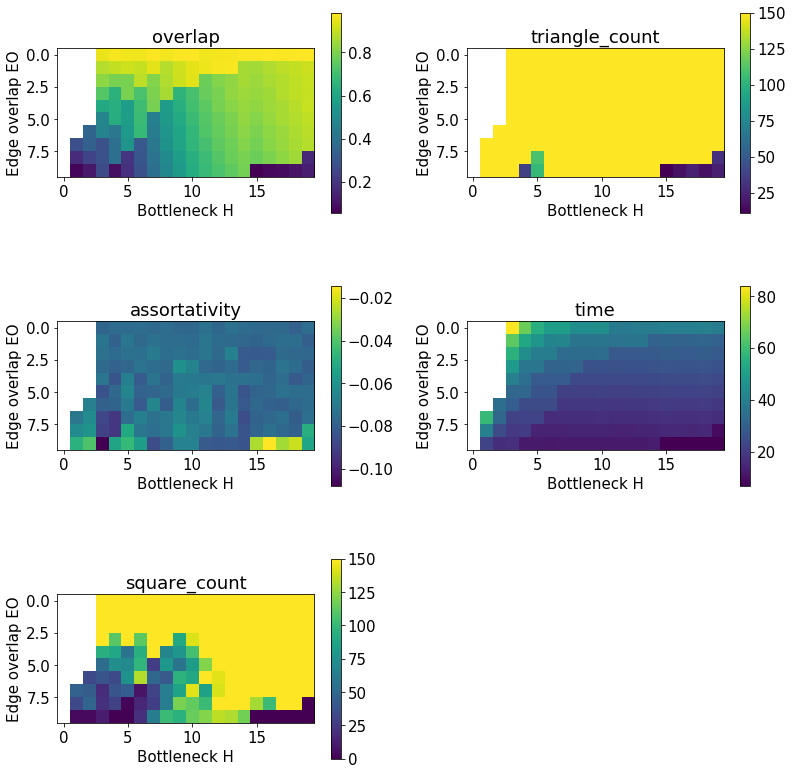

In [14]:
make_H_EO_grid_heatplot(dict_of_dicts_of_statistics=dict_of_dicts_of_statistics,
                        Hs=Hs,
                        EOs=EOs,
                        keys=['overlap',
                              'triangle_count', 
                              'assortativity',                            
                              'time',
                              'square_count'])

# make_H_EO_grid_heatplot(dict_of_dicts_of_statistics=dict_of_dicts_of_statistics, Hs=Hs, EOs=EOs, keys=['time'])

In [16]:
times = np.zeros((len(Hs),len(EOs)))
times.fill(None)

for key, value in dict_of_dicts_of_statistics.items():
    times[key[0], key[1]] = value['time']

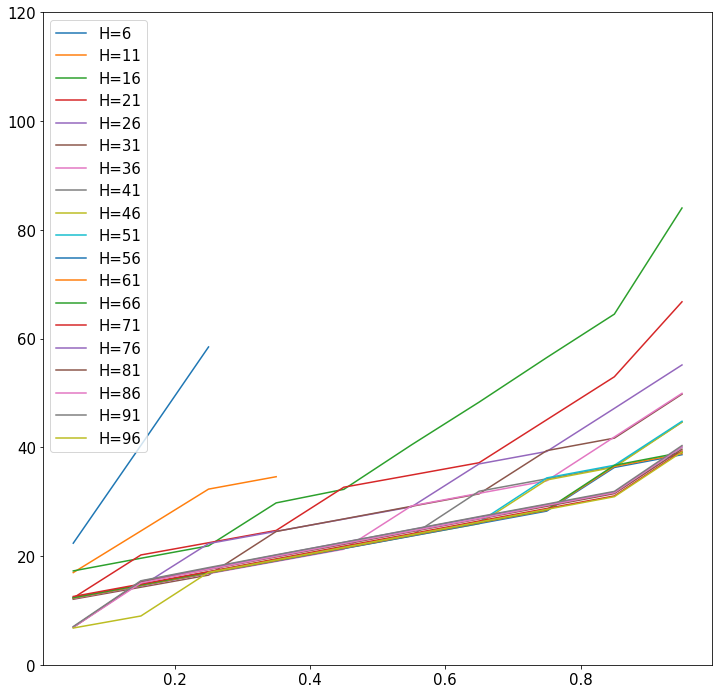

In [17]:
f, axs = plt.subplots(figsize=(12,12))

for i in range(len(Hs)):
    if not np.isnan(times[i]).all():
        axs.plot(EOs, times[i], label=f'H={Hs[i]}')

plt.ylim(0,120)            
plt.legend()
plt.show()